# Model design and training
Here we will design the GNN and train on the data we already processed.

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.nn import GELU
from torch.nn import Linear
from torch.nn import ModuleList
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
import time


path_to_data = '../data/global-daily-climate-data/graphs.pt'
if not(os.path.exists(path_to_data)): 
    raise FileNotFoundError(f'The file at path {path_to_data} does not exist.')

cities_nearby = ['Mersin', 'Latakia', 'Tartus', 'Tripoli', 'Hama', 'Nazareth', 'Tel Aviv', 
                 'Damascus', 'Heraklion', 'Athens', 'Damanhur']
cities_target = 'Larnaca'

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


In [2]:
# Load the data from the specified path
data = torch.load(path_to_data)

print(f'Number of graphs: {len(data)}')
print(f'Graph keys: {data[0].keys()}')
example_graph = data[0]
print(f'Graph keys: {example_graph["edge_attr"]}')
print(f'Example Edge attributes: {example_graph["edge_attr"]}')
print(f'Example x: {example_graph["x"]}')
print(f'Example edge indices: {example_graph["edge_index"]}')
print(f'Example y: {example_graph["y"]}')

/var/folders/jz/41k9wxbs41j1jh51j2ysq5wh0000gp/T/ipykernel_2659/1159538383.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path_to_data)


Number of graphs: 16475
Graph keys: ['x', 'edge_attr', 'edge_index', 'y']
Graph keys: tensor([[ -5.2842,  11.5760],
        [ -2.6391,  10.1593],
        [ -2.2104,   1.6735],
        [  5.2842, -11.5760],
        [  2.6451,  -1.4167],
        [  3.0738,  -9.9025],
        [  2.6391, -10.1593],
        [ -2.6451,   1.4167],
        [  0.4287,  -8.4858],
        [  2.2104,  -1.6735],
        [ -3.0738,   9.9025],
        [ -0.4287,   8.4858],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000],
        [  1.0000,   1.0000]])
Example Edge attributes: tensor([[ -5.2842,  11.5760],
        [ -2.6391,  10.1593],
        [ -2.2104,   1.6735],
        [  5.2842, -11.5760],
        [  2.6451,  -1.4167],
        [  3.0738,  -9.9025],
        [  2.6391, -10.1593],
        [ -2.6451,   1.4167],
        [  0.4287,  -8.4858],
        [  2.2104,

# Model Design/Architecture

In [ ]:
class GraphConvNet(torch.nn.Module):
    def __init__(self, input_dim = 9, hidden_dim = 256, out_dim = 4, dropout = 0.2, hidden_layers = 5):
        super(GraphConvNet, self).__init__()

        self.convs = ModuleList()

        # Input layer
        self.convs.append(GCNConv(input_dim, hidden_dim))

        # hidden layers
        for i in range(3):
            for _ in range(hidden_layers):
                self.convs.append(GCNConv(hidden_dim, hidden_dim))

            # reducing the hidden dimension size
            self.convs.append(GCNConv(hidden_dim, int(hidden_dim/2)))
            hidden_dim = int(hidden_dim/2)

        # Output layer
        self.linear_out = Linear(hidden_dim, out_dim)

        # extras
        self.gelu = GELU()
        self.dropout = dropout

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.gelu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = global_mean_pool(x, batch)

        x = self.linear_out(x)
        return x

model = GraphConvNet()
model = model.to(device)
print(model)

GraphConvNet(
  (convs): ModuleList(
    (0): GCNConv(9, 256)
    (1-5): 5 x GCNConv(256, 256)
    (6): GCNConv(256, 128)
    (7-11): 5 x GCNConv(128, 128)
    (12): GCNConv(128, 64)
    (13-17): 5 x GCNConv(64, 64)
    (18): GCNConv(64, 32)
  )
  (linear_out): Linear(in_features=32, out_features=4, bias=True)
  (gelu): GELU(approximate='none')
)


We want to use 60% of the data for training, 20% for testing, and the rest for validation later.

In [4]:
train_frac = 0.6
test_frac = 0.2
val_frac = 0.2

data_train = data[int(len(data) * train_frac):]
data_test = data[int(len(data) * train_frac):int(len(data) * train_frac) + int(len(data) * test_frac)]
data_val = data[int(len(data) * train_frac) + int(len(data) * test_frac):int(len(data) * train_frac) + int(len(data) * test_frac) + int(len(data) * val_frac)]

loader_train = DataLoader(data_train, batch_size = 32, shuffle = False)
loader_test = DataLoader(data_test, batch_size = 32, shuffle = False)
loader_val = DataLoader(data_val, batch_size = 32, shuffle = False)

In [5]:
epochs = 100
learning_rate = 0.0001
weight_decay = 1e-4

optimizer = Adam(model.parameters(), lr = learning_rate, weight_decay = weight_decay)
criterion = torch.nn.MSELoss()

loss_train, loss_test = [], []

# early stopping
best_loss = float('inf')
epochs_no_improve = 0
patience = 5

model.train()
for epoch in range(1, epochs + 1):
    start = time.time()
    total_loss_train= 0
    total_loss_test = 0

    total_graphs_train = 0
    total_graphs_test = 0

    # training loop
    model.train()
    for batch in loader_train:
        batch = batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index, batch.batch)

        loss = criterion(out, batch.y.view(-1, 4))
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item() * batch.num_graphs
        total_graphs_train += batch.num_graphs
    
    avg_loss_train = total_loss_train / total_graphs_train
    
    # test loop
    model.eval()
    with torch.no_grad():
        for batch in loader_test:
            batch = batch.to(device)

            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.view(-1, 4))

            total_loss_test += loss.item() * batch.num_graphs
            total_graphs_test += batch.num_graphs

    avg_loss_test = total_loss_test / total_graphs_test
    
    loss_train.append(avg_loss_train)
    loss_test.append(avg_loss_test)
    end = time.time()
    print(f'Epoch {epoch:03d}/{epochs}:\tTrain Loss = {avg_loss_train:.4f},\tTest Loss = {avg_loss_test:.4f},\tt = {end - start:.1f} sec')


    # Early stopping check
    if avg_loss_test < best_loss:
        best_loss = avg_loss_test
        best_epoch = epoch
        epochs_no_improve = 0
        # Optionally save the best model state here
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch} epochs with no improvement. Returning state at epoch {best_epoch}.')
        break

# Optionally, load best model weights after stopping
model.load_state_dict(best_model_state)

Epoch 001/100:	Train Loss = 196.5029,	Test Loss = 20.0434,	t = 66.1 sec
Epoch 002/100:	Train Loss = 29.6148,	Test Loss = 18.2528,	t = 13.5 sec
Epoch 003/100:	Train Loss = 27.4757,	Test Loss = 18.9231,	t = 13.0 sec
Epoch 004/100:	Train Loss = 27.7333,	Test Loss = 17.8932,	t = 13.4 sec
Epoch 005/100:	Train Loss = 25.5736,	Test Loss = 18.1112,	t = 13.4 sec
Epoch 006/100:	Train Loss = 27.8478,	Test Loss = 17.2358,	t = 13.0 sec
Epoch 007/100:	Train Loss = 25.0384,	Test Loss = 18.4809,	t = 12.9 sec
Epoch 008/100:	Train Loss = 23.2880,	Test Loss = 18.1312,	t = 13.0 sec
Epoch 009/100:	Train Loss = 24.5172,	Test Loss = 19.2790,	t = 13.2 sec
Epoch 010/100:	Train Loss = 26.0006,	Test Loss = 16.7006,	t = 13.3 sec
Epoch 011/100:	Train Loss = 24.1327,	Test Loss = 16.6194,	t = 13.2 sec
Epoch 012/100:	Train Loss = 22.3070,	Test Loss = 16.3864,	t = 12.9 sec
Epoch 013/100:	Train Loss = 21.6113,	Test Loss = 16.3344,	t = 12.9 sec
Epoch 014/100:	Train Loss = 21.0163,	Test Loss = 16.3115,	t = 13.2 sec
Epoch

<All keys matched successfully>

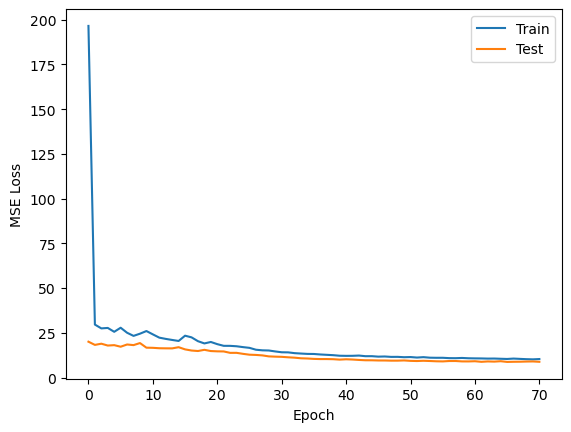

In [6]:
plt.plot(loss_train, label='Train')
plt.plot(loss_test, label='Test')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.show()

In [7]:
model.eval()

GraphConvNet(
  (convs): ModuleList(
    (0): GCNConv(9, 256)
    (1-5): 5 x GCNConv(256, 256)
    (6): GCNConv(256, 128)
    (7-11): 5 x GCNConv(128, 128)
    (12): GCNConv(128, 64)
    (13-17): 5 x GCNConv(64, 64)
    (18): GCNConv(64, 32)
  )
  (linear_out): Linear(in_features=32, out_features=4, bias=True)
  (gelu): GELU(approximate='none')
)

In [8]:
model.eval()
predictions = []

with torch.no_grad():
    for batch in loader_val:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index, batch.batch)
        predictions.append(out.cpu())

# Combine all predictions into a single tensor
predictions = torch.cat(predictions, dim=0) if predictions else torch.tensor([])

In [9]:
truth = torch.stack([data.y for data in loader_val.dataset])
truth.shape

torch.Size([3295, 4])

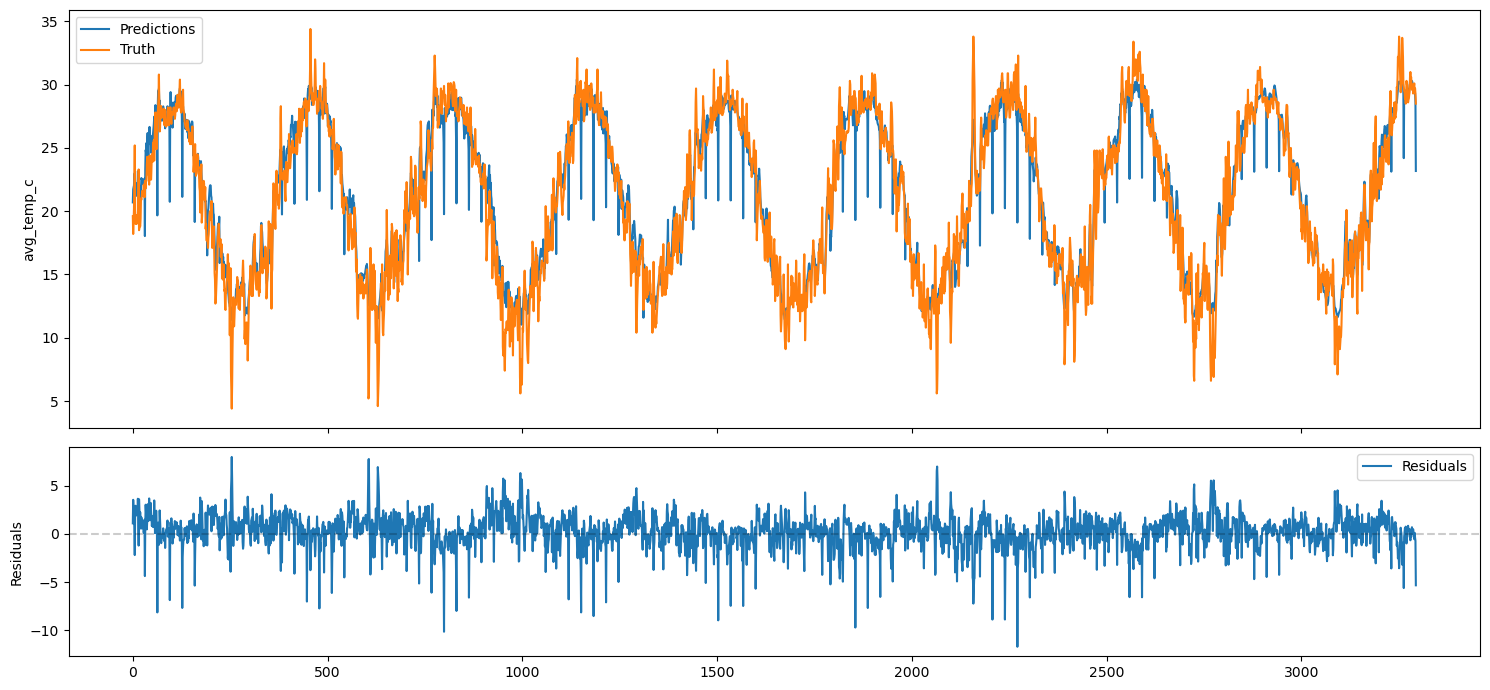

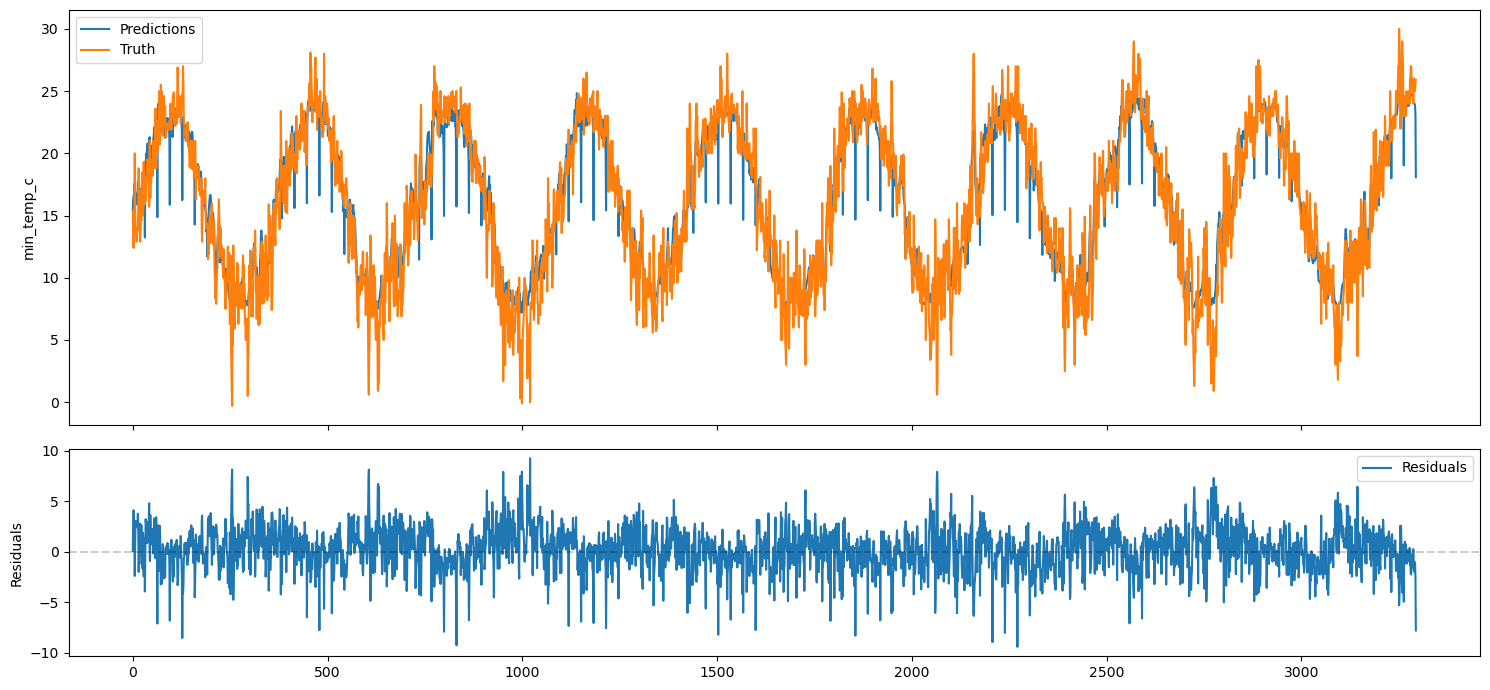

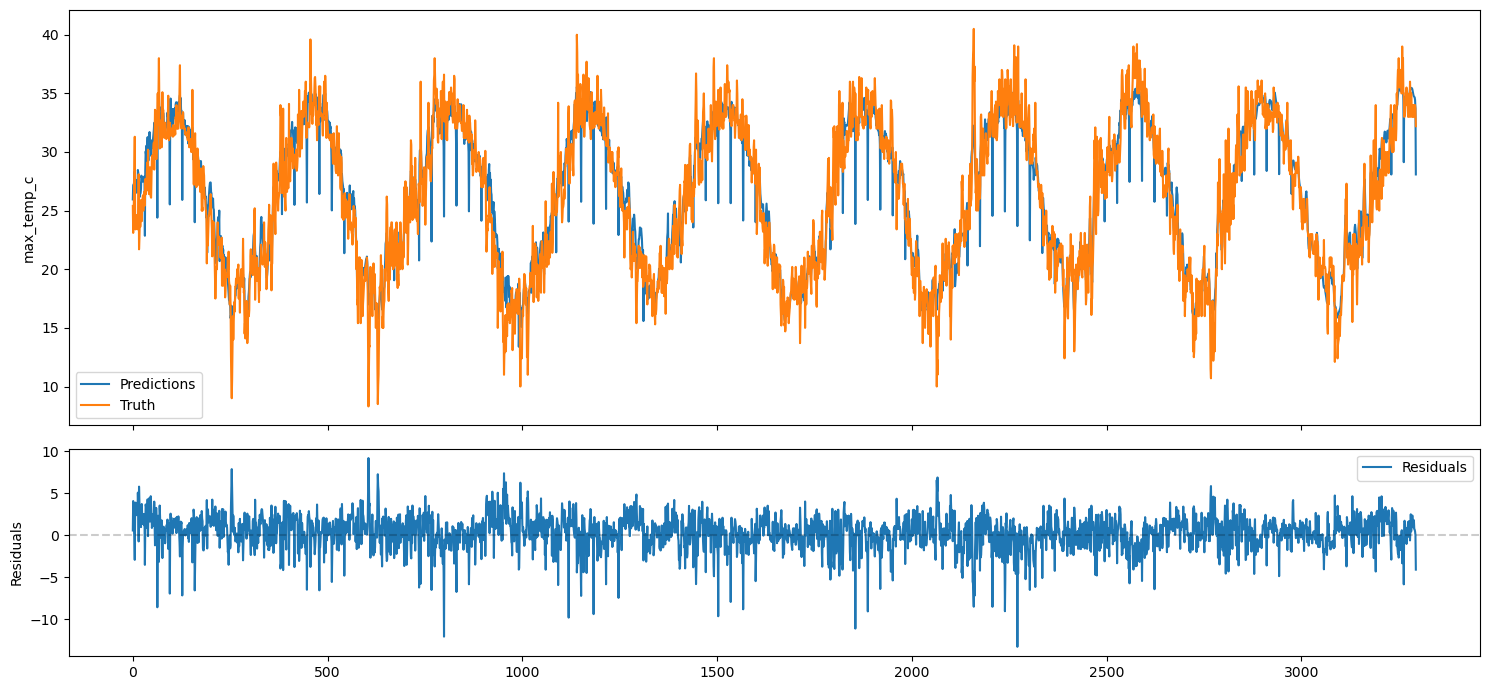

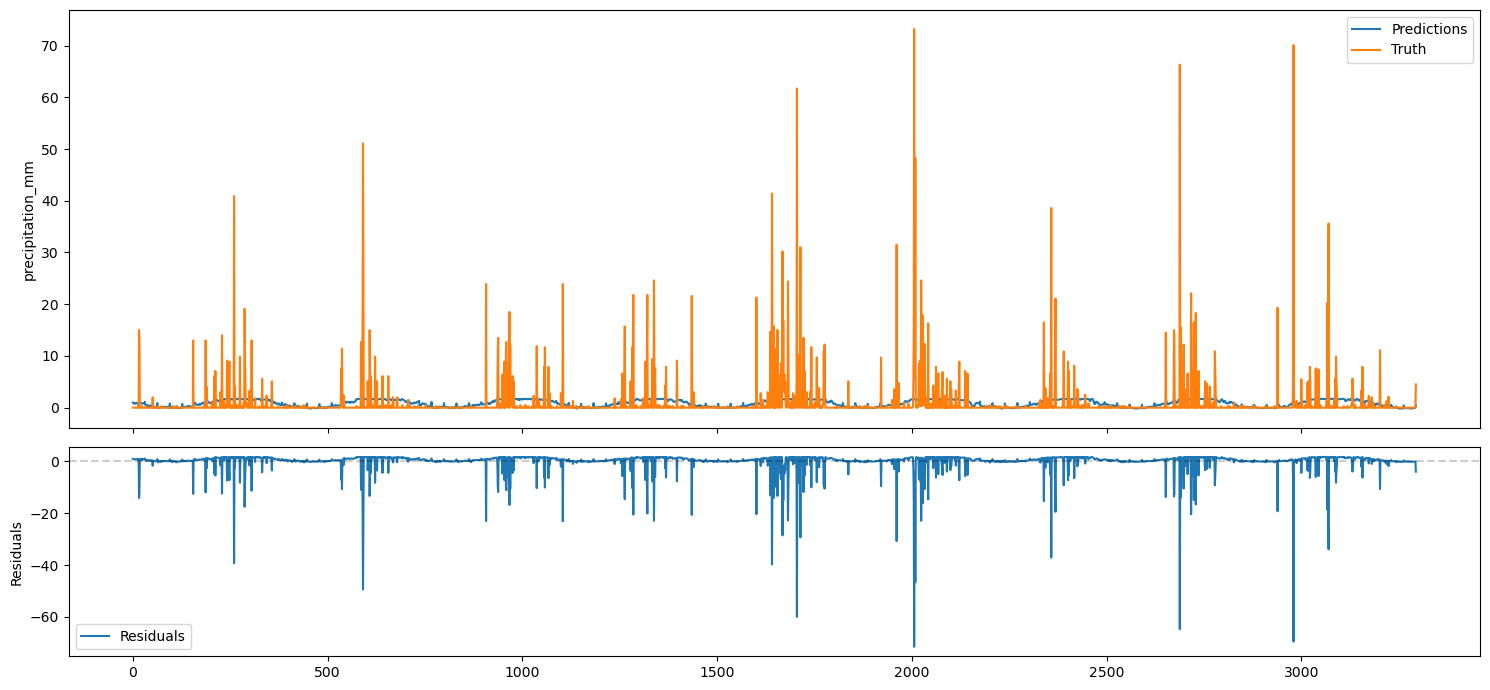

In [10]:
values = ['avg_temp_c', 'min_temp_c', 'max_temp_c', 'precipitation_mm']

for i in range(truth.shape[1]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15,7))
    ax1.plot(predictions[:, i].numpy(), label='Predictions')
    ax1.plot(truth[:, i].numpy(), label='Truth')
    ax1.legend()
    ax1.set_ylabel(values[i])

    ax2.plot(predictions[:, i].numpy() - truth[:, i].numpy(), label='Residuals')
    ax2.axhline(y = 0, color = 'black', alpha = 0.2, ls = '--')
    ax2.legend()
    ax2.set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()

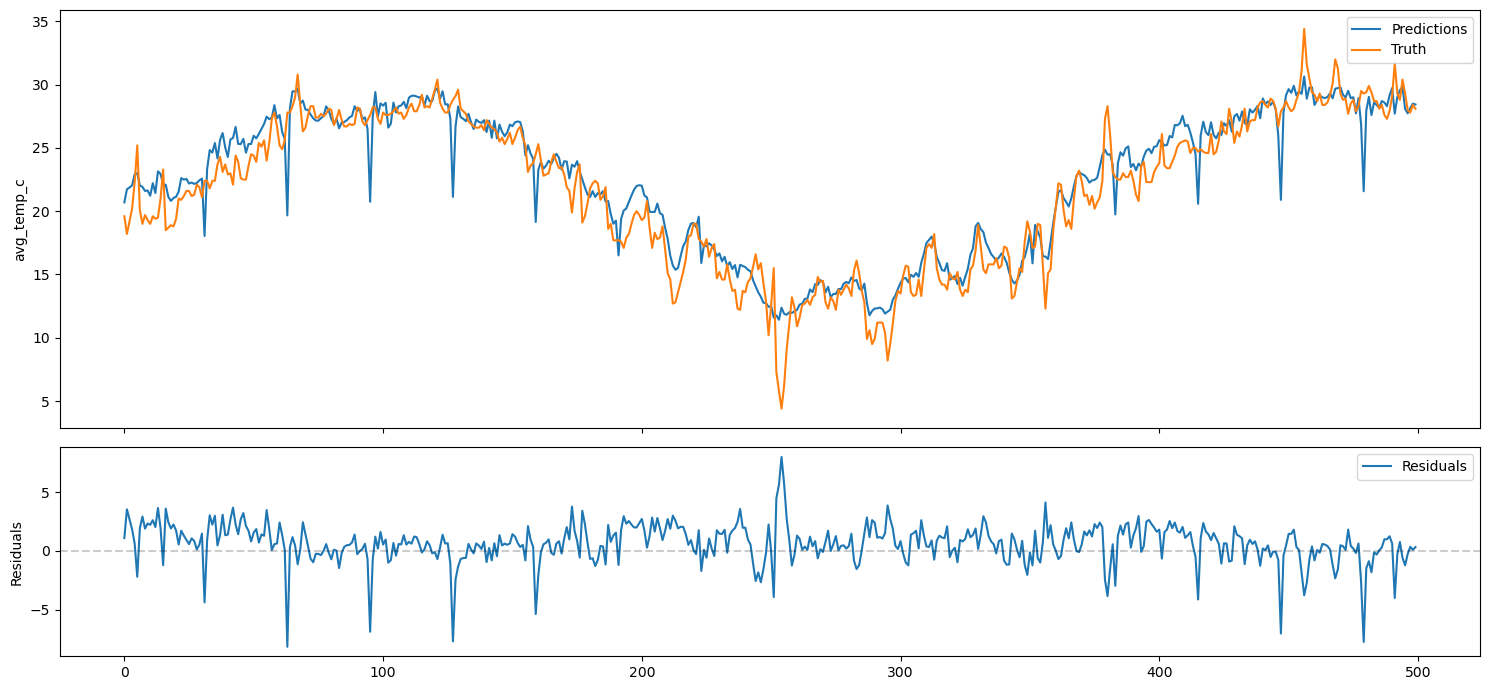

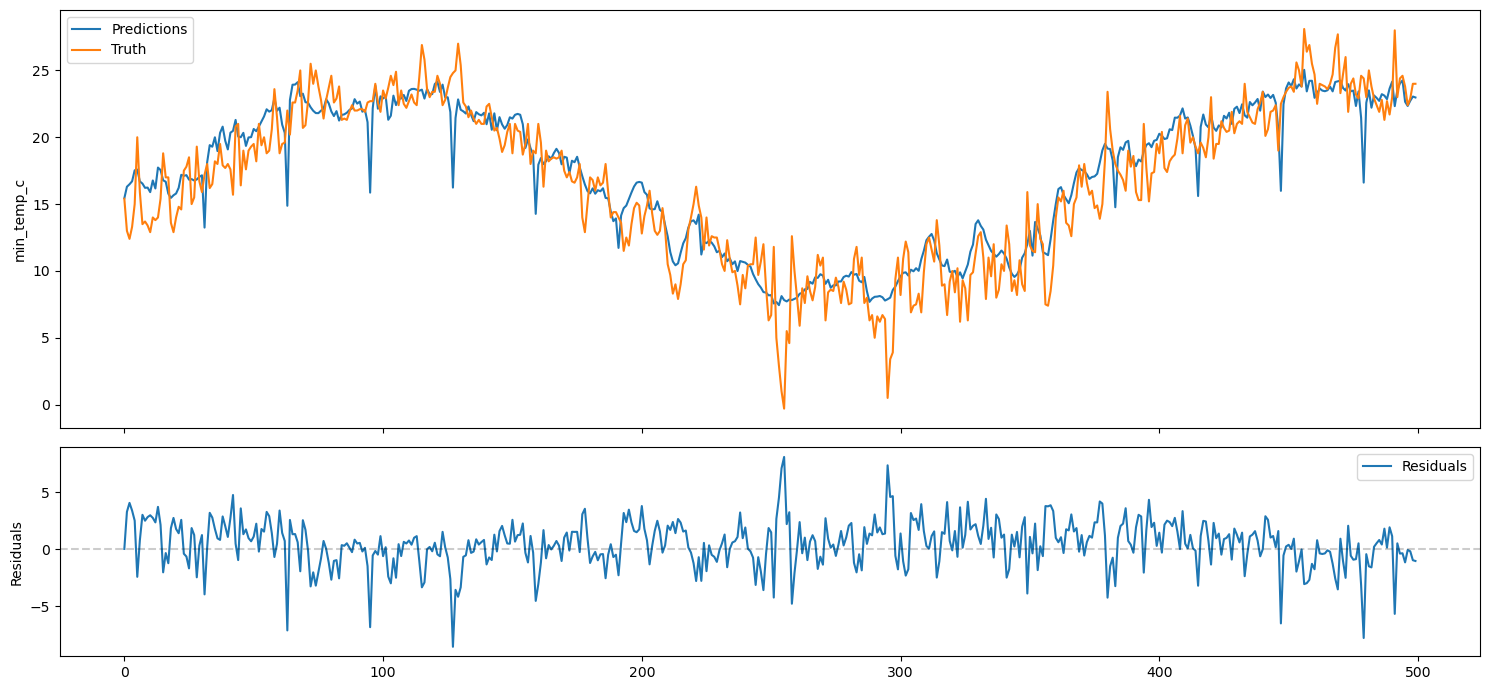

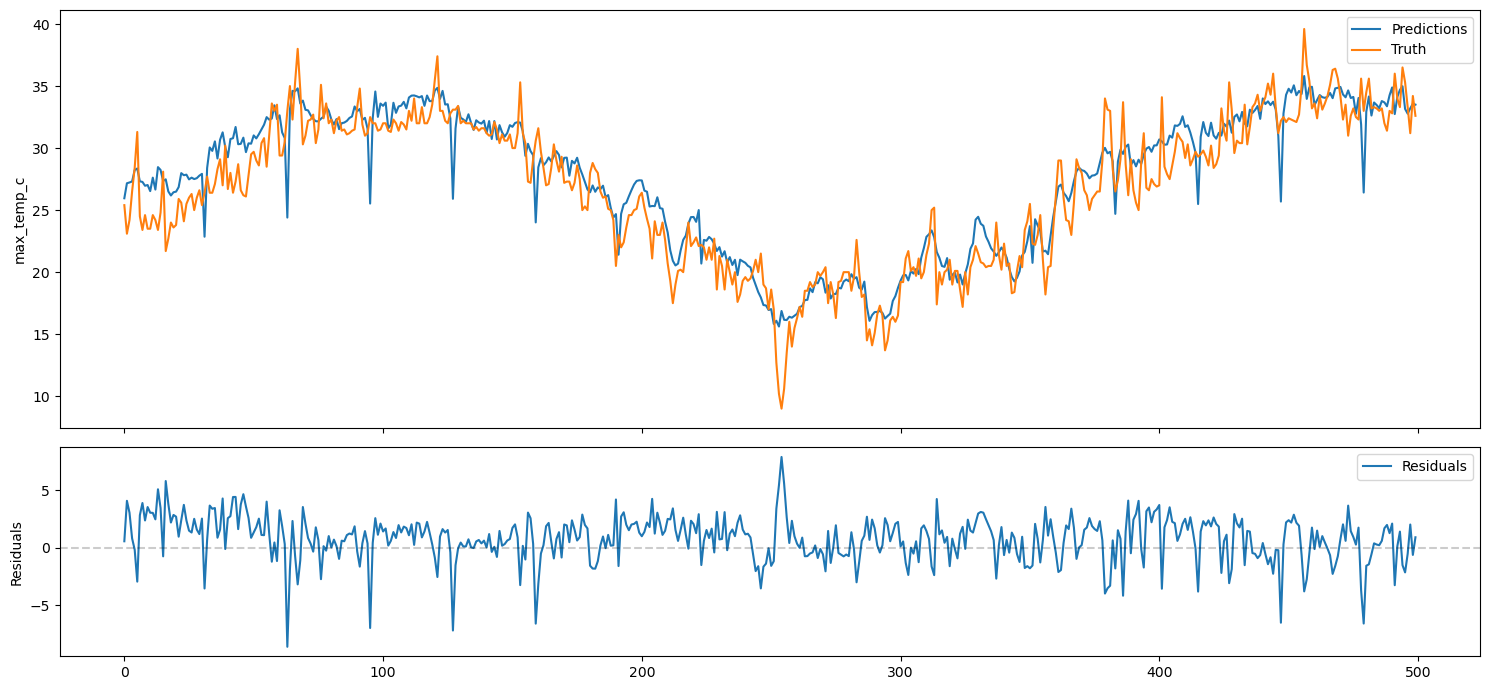

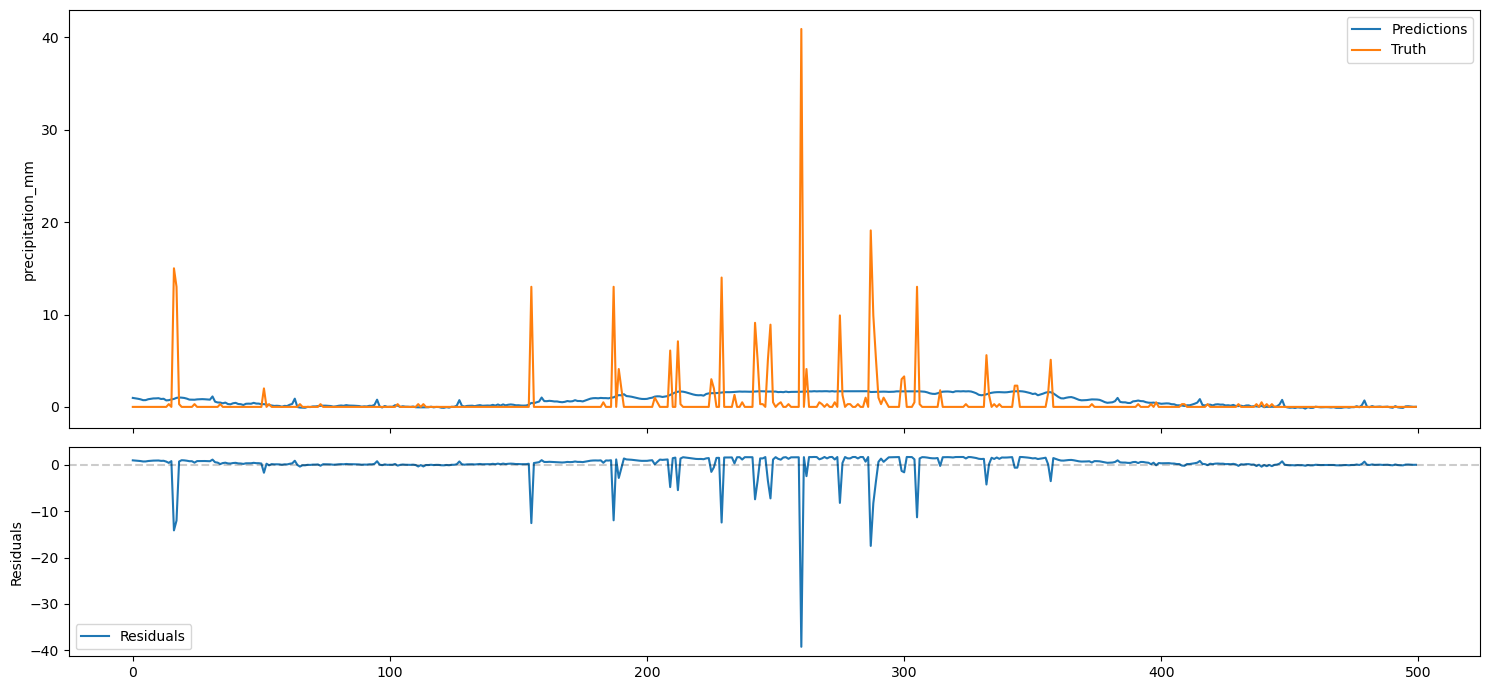

In [11]:
limit = 500
for i in range(truth.shape[1]):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15,7))
    ax1.plot(predictions[:limit, i].numpy(), label='Predictions')
    ax1.plot(truth[:limit, i].numpy(), label='Truth')
    ax1.legend()
    ax1.set_ylabel(values[i])

    ax2.plot(predictions[:limit, i].numpy() - truth[:limit, i].numpy(), label='Residuals')
    ax2.axhline(y = 0, color = 'black', alpha = 0.2, ls = '--')
    ax2.legend()
    ax2.set_ylabel('Residuals')

    plt.tight_layout()
    plt.show()